<a href="https://colab.research.google.com/github/fredericpoitevin/tseries-deconvolution/blob/master/Deconvolving_causal_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are interested in the following scenario:
We have access to two cumulative time-series that we call cause (or _cases_ $C(t)$ the total number of cases at time $t$) and consequence (or _deaths_ $D(t) $ the total number of deaths at time $t$). We assume that consequence is cause convolved with an unknown kernel $K$, and we are interested in inferring the kernel function, or at least its parameters.

Formally, 

$$\frac{\partial D}{\partial \tau}|_{\tau=t} = \sum_{s=0}^{t} K(t-s)\frac{\partial C}{\partial \tau}|_{\tau=s}$$

We have access to samples of the cumulative time-series at fixed time intervals $\Delta t$, we can thus discretize the above equation with finite difference. For $i \geq 1$, we introduce $f_{i} = \frac{F(i\Delta t) - F((i-1)\Delta t)}{\Delta t}$:

$$d_{i} = \sum_{j=1}^{i}k_{ij}c_{j}$$

# Illustrative example

For now we assume that $c$ and $k$ are gaussian and we look at $d$:

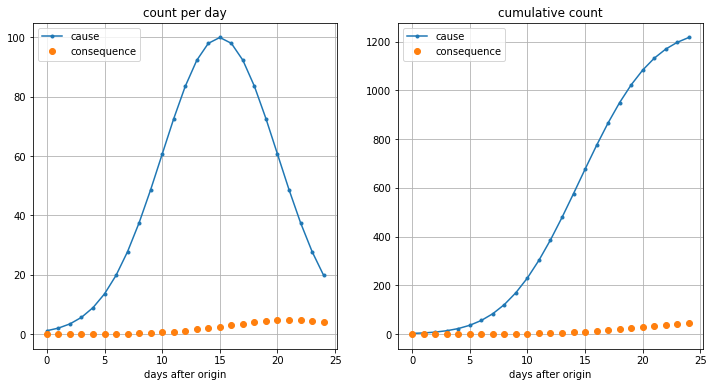

In [101]:
import numpy as np
from matplotlib import pyplot as plt
ndays=25
i = np.arange(-ndays,ndays)
c = build_c(i, mode='gaussian', params=[100,15,5])
k = build_k(i, mode='gaussian', params=[0.05,5,2])
d = build_d(i, cause=c, kernel=k)
display(ndays,c=c,d=d)

If we know the kernel, we can deconvolve:

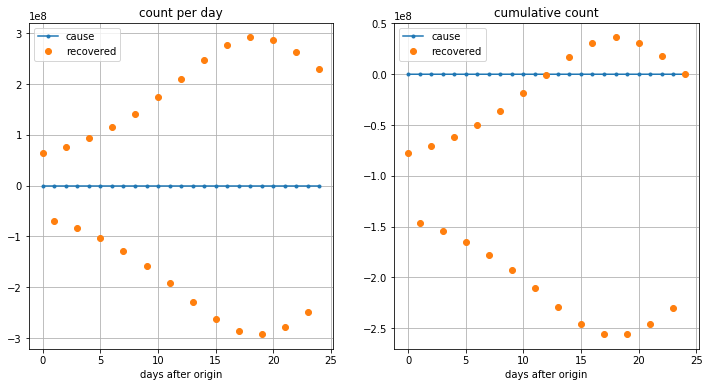

In [102]:
d_fft = np.fft.fft(d)
k_fft = np.fft.fft(k)
c_recovered_fft = d_fft/k_fft
c_recovered = np.roll(np.real(np.fft.ifft(c_recovered_fft)),ndays-1)
display(ndays,c=c,d=c_recovered, labels=['cause', 'recovered'])

We see what is likely an antialiasing effect: further characterization is needed here...

In principle, knowing the cause and the consequence, we can retrieve the kernel. Here to deal with divide by zero, we use a Wiener filtering approach to deconvolving:



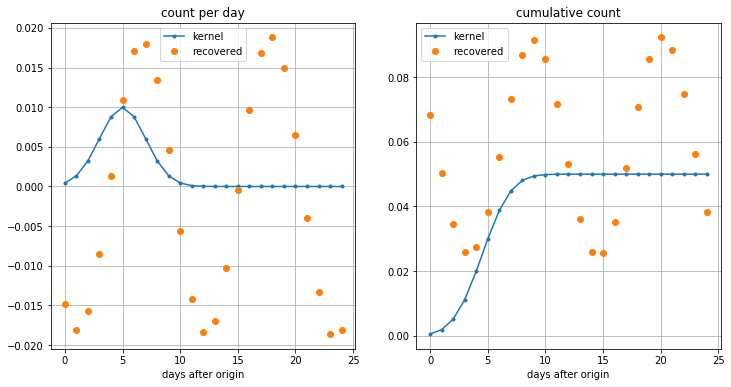

In [103]:
d_fft = np.fft.fft(d)
c_fft = np.fft.fft(c)
k_recovered_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2+0.1)
k_recovered = np.roll(np.real(np.fft.ifft(k_recovered_fft)),ndays-1)
display(ndays,c=k,d=k_recovered, labels=['kernel', 'recovered'])

Here too we see what is likely an antialiasing effect. To be corrected soon...

# Coronavirus dataset

## Dataset curated by Michael

We load the data, then display it, and deconvolve it below:

In [3]:
import numpy as np
from google.colab import files
uploaded = files.upload()

In [97]:
data = np.genfromtxt('/content/tseries.csv', delimiter=',', comments='#', skip_header=1, usecols=(2,3,4,5,6,7,8,9))
ndays=data.shape[0]
data_pad = np.zeros(data.shape)
data_padded = np.stack((data_pad, data), axis=0).reshape(2*data.shape[0], data.shape[1])
print(data_padded.shape)

(52, 8)


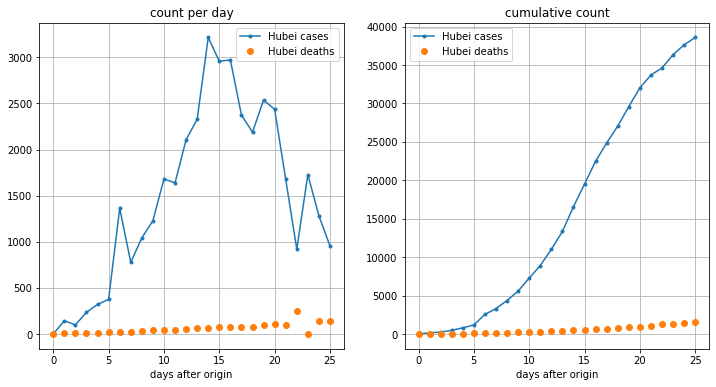

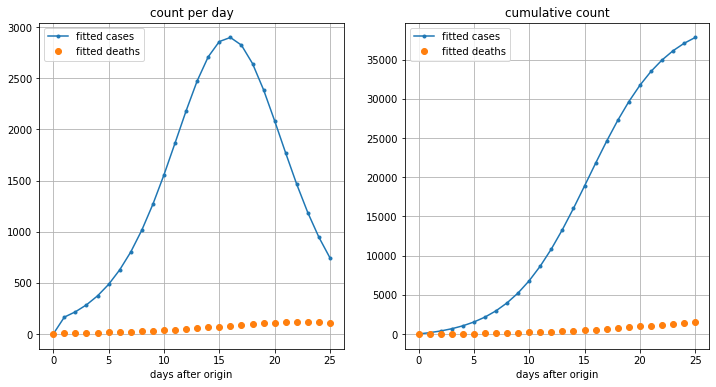

In [98]:
display(ndays,c=data_padded[:,4],d=data_padded[:,5], labels=['Hubei cases', 'Hubei deaths'])
display(ndays,c=data_padded[:,6],d=data_padded[:,7], labels=['fitted cases', 'fitted deaths'])

### Deconvolving the sigmoid fits
Below we recovere the kernel retrieve from the sigmoid fits:

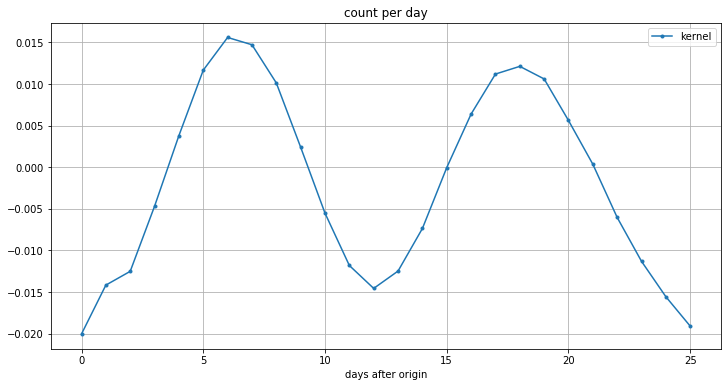

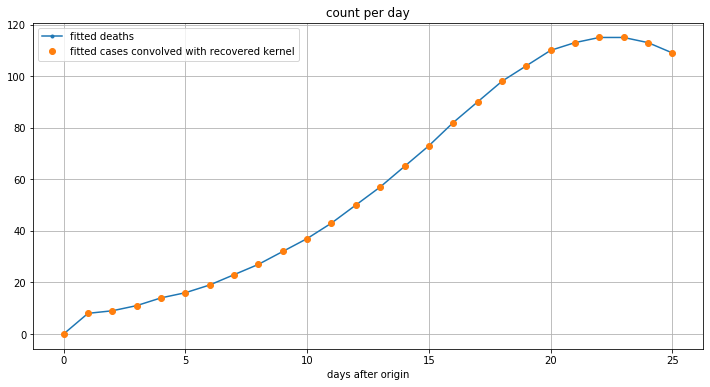

In [100]:
d_fft = np.fft.fft(data_padded[:,7])
c_fft = np.fft.fft(data_padded[:,6])
k_recovered_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2)
k_recovered = np.roll(np.real(np.fft.ifft(k_recovered_fft)),ndays-1)
display(ndays,c=k_recovered, labels=['kernel', ], show_cumul=False)
d_reconstruction = build_d(np.arange(-ndays,ndays), cause=data_padded[:,6], kernel=k_recovered)
display(ndays,c=data_padded[:,7],d=d_reconstruction, labels=['fitted deaths', 'fitted cases convolved with recovered kernel'], show_cumul=False)

As in the illustrative example, we see what is likely an antialiasing effect...

### Deconvolving the raw data

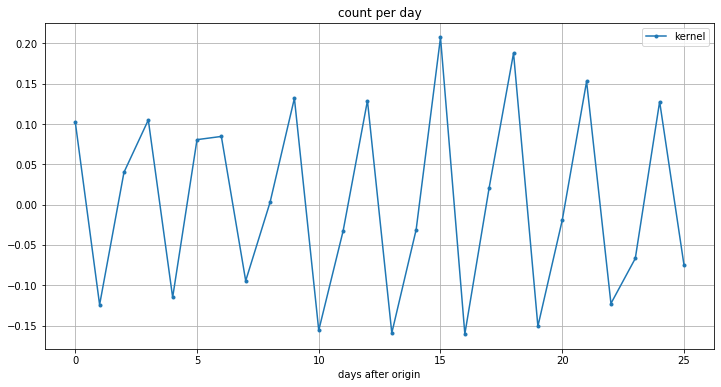

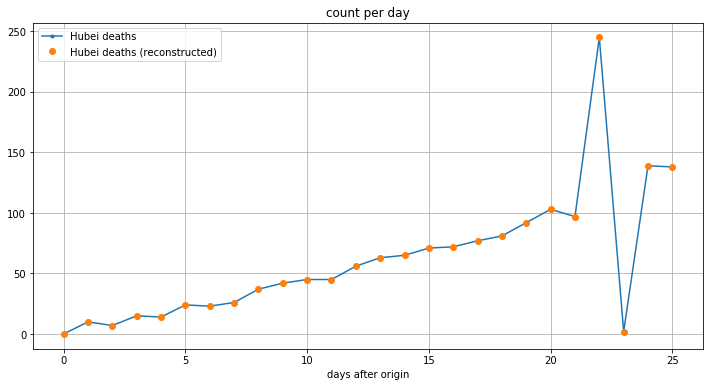

In [99]:
d_fft = np.fft.fft(data_padded[:,5])
c_fft = np.fft.fft(data_padded[:,4])
k_recovered_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2+0)
k_recovered = np.roll(np.real(np.fft.ifft(k_recovered_fft)),ndays-1)
display(ndays,c=k_recovered, labels=['kernel', ], show_cumul=False)
d_reconstruction = build_d(np.arange(-ndays,ndays), cause=data_padded[:,4], kernel=k_recovered)
display(ndays,c=data_padded[:,5],d=d_reconstruction, labels=['Hubei deaths', 'Hubei deaths (reconstructed)'], show_cumul=False)

## Kaggle dataset

In [0]:
# Colab library to upload files to notebook
from google.colab import files
# Install Kaggle library
!pip install -q kaggle
# Upload kaggle API key file
uploaded = files.upload()
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

Saving kaggle.json to kaggle.json


In [0]:
# Download dataset
!kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset

  0% 0.00/22.6k [00:00<?, ?B/s]
100% 22.6k/22.6k [00:00<00:00, 40.9MB/s]


In [0]:
# unzip dataset
!unzip /content/*.zip

Archive:  /content/novel-corona-virus-2019-dataset.zip
  inflating: 2019_nCoV_data.csv      
  inflating: time_series_2019_ncov_confirmed.csv  
  inflating: time_series_2019_ncov_deaths.csv  
  inflating: time_series_2019_ncov_recovered.csv  


In [0]:
import numpy as np
cases  = np.genfromtxt('/content/time_series_2019_ncov_confirmed.csv', 
                     delimiter=',', filling_values=0,
                     names=True, invalid_raise=False)
deaths = np.genfromtxt('/content/time_series_2019_ncov_deaths.csv', 
                     delimiter=',', filling_values=0,
                     names=True, invalid_raise=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConversionWarning: Some errors were detected !
    Line #37 (got 41 columns instead of 40)
    Line #38 (got 41 columns instead of 40)
    Line #39 (got 41 columns instead of 40)
    Line #47 (got 41 columns instead of 40)
    Line #49 (got 41 columns instead of 40)
    Line #50 (got 41 columns instead of 40)
    Line #61 (got 41 columns instead of 40)
    Line #66 (got 41 columns instead of 40)
    Line #69 (got 41 columns instead of 40)
    Line #70 (got 41 columns instead of 40)
    Line #72 (got 41 columns instead of 40)
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ConversionWarning: Some errors were detected !
    Line #36 (got 41 columns instead of 40)
    Line #37 (got 41 columns instead of 40)
    Line #38 (got 41 columns instead of 40)
    Line #47 (got 41 columns instead of 40)
    Line #49 (got 41 columns instead of 40)
    Line #50 (got 41 columns inste

In [0]:
cases_type = cases.dtype
print('Data column names: {}'.format(cases_type.names))
cases_data = np.array(cases.tolist())[:,4:]
print('Keeping the data only (skipping first 4 columns). Resulting array shape: {}'.format(cases_data.shape))
cases_total = np.sum(cases_data,axis=0)
#
deaths_type = deaths.dtype
print('Data column names: {}'.format(deaths_type.names))
deaths_data = np.array(deaths.tolist())[:,4:]
print('Keeping the data only (skipping first 4 columns). Resulting array shape: {}'.format(deaths_data.shape))
deaths_total = np.sum(deaths_data,axis=0)

Data column names: ('\ufeffProvinceState', 'CountryRegion', 'Lat', 'Long', '12120_2200', '12220_1200', '12320_1200', '12420_000', '12420_1200', '12520_000', '12520_1200', '12520_2200', '12620_1100', '12620_2300', '12720_900', '12720_1900', '12720_2030', '12820_1300', '12820_1800', '12820_2300', '12920_1330', '12920_1430', '12920_2100', '13020_1100', '13120_1400', '020120_1000', '020220_2100', '020320_2100', '020420_940', '020420_2200', '020520_900', '020520_2300', '020620_900', '020620_1420', '020720_2013', '020720_2250', '020820_2204', '020820_2304', '020920_1030', '020920_2320')
Keeping the data only (skipping first 4 columns). Resulting array shape: (61, 36)
Data column names: ('\ufeffProvinceState', 'CountryRegion', 'Lat', 'Long', '12120_2200', '12220_1200', '12320_1200', '12420_000', '12420_1200', '12520_000', '12520_1200', '12520_2200', '12620_1100', '12620_2300', '12720_900', '12720_1900', '12720_2030', '12820_1300', '12820_1800', '12820_2300', '12920_1330', '12920_1430', '12920

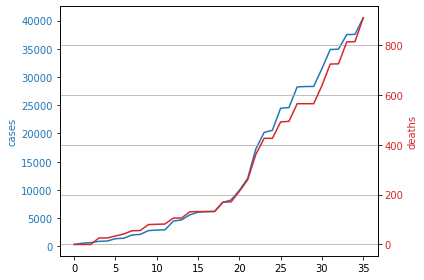

In [0]:

#t = np.arange(0.01, 10.0, 0.01)
data1 = cases_total
data2 = deaths_total

fig, ax1 = plt.subplots()

color = 'tab:blue'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('cases', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('deaths', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Toolkit

In [0]:
def build_c(i, mode='gaussian', params=None):
  """build_c
  """
  if params is None:
    print('ERROR. no param given...')
  else:
    if(mode=='gaussian'):
      amplitude = params[0]
      t_origin  = params[1]
      t_spread  = params[2]
      c = amplitude*np.exp(-(i-t_origin)**2/(2*t_spread**2))
    return c

def build_k(i, mode='gaussian', params=None):
  """build_k
  """
  if params is None:
    print('ERROR. no param given...')
  else:
    if(mode=='gaussian'):
      amplitude = params[0]/(np.sqrt(2*np.pi)*params[2])
      t_origin  = params[1]
      t_spread  = params[2]
      k = amplitude*np.exp(-(i-t_origin)**2/(2*t_spread**2))
    return k

def build_d(i, cause=None, kernel=None):
  """build_d
  """
  if cause is not None:
    if kernel is not None:
      d = np.convolve(kernel,cause,mode='same')
      return d

def display(ndays,c=None, d=None, labels=['cause', 'consequence'], show_cumul=True):
  ncol=1
  if show_cumul:
    ncol=2
  trange=np.arange(ndays)
  tzero = ndays
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,ncol,1)
  plt.title('count per day')
  plt.xlabel('days after origin')
  if c is not None:
    plt.plot(trange,c[tzero:], '.-', label=labels[0])
  if d is not None:
    plt.plot(trange,d[tzero:], 'o', label=labels[1])
  plt.grid()
  plt.legend()
  if show_cumul:
    plt.subplot(1,ncol,2)
    plt.title('cumulative count')
    plt.xlabel('days after origin')
    if c is not None:
      plt.plot(trange,np.cumsum(c)[tzero:], '.-', label=labels[0])
    if d is not None:
      plt.plot(trange,np.cumsum(d)[tzero:], 'o', label=labels[1])
    plt.grid()
    plt.legend()